# Generative Adversarial Networks

Generative adversarial networks (GANs) are a machine learning approach inspired by game theory. These models consist of two neural networks, a generator and a discriminator, competing against one another. The generator attempts to create synthetic data similar to a given data distribution (i.e., images, text, ect.), while the discriminator attempts to distinguish between real and fake data. These models are adversarial because the learning objective of the generator and the discriminator are often to increase the error rate of the other.

In this example, we are going to use adversarial learning to build a generator capable of generating points of the form $(x,f(x))$, where $f$ is some user-defined function specified below.

# Table of Contents

1. [Generative Adversarial Networks](#Generative-Adversarial-Networks)
2. [Imports](#Imports)
3. [Obtaining "Real" Data](#Obtaining-"Real"-Data)
4. [The Latent Space](#The-Latent-Space)
5. [Adversarial Learning](#Adversarial-Learning)
    1. [Models](#Models)
        1. [The Generator](#The-Generator)
        2. [The Discriminator](#The-Discriminator)
6. [Adversarial Learning](#Adversarial-Learning)
    1. [Placeholder Variables](#Placeholder-Variables)
    2. [Compuate Graphs](#Compuate-Graphs)
    3. [Loss Functions](#Loss-Functions)
    4. [Optimizers](#Optimizers)
7. [Training](#Training)
    1. [Parameters](#Parameters)
    2. [Training Loop](#Training-Loop)

# Imports

In [1]:
## uncomment the following line for google colab
# %tensorflow_version 1.x

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import tensorflow as tf

from IPython.display import clear_output

In [2]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version: 1.15.0
Num GPUs Available: 0


# Obtaining "Real" Data

During training, the discriminator is presented with real data samples of interest as well as synthetic data samples created by the generator. We are going to train the generator to create points of the form $(x,f(x))$ and the discriminator to distinguish between them. In this example, our function $f$ will be $f(x)=2x^{3}-3x^{2}-3x+2$.

The `data_function` variable below defines our function $f$, and the `data_vmin` and `data_vmax` variables control the domain of the function. We will generate `n_data_sampels` and store them in the `data` variable to represent our "real" data of interest.

In [3]:
n_data_samples=1000
data_vmin = -2
data_vmax = 3
data_function = lambda xx: 2*xx**3 - 3*xx**2 - 3*xx + 2

# n_data_samples=1000
# data_vmin = -100
# data_vmax = 100
# data_function = lambda xx: xx**2 + 10

def generate_data(n_samples=1000, vmin=-100, vmax=100, function=lambda x:10+x**2):
    xx = np.random.uniform(low=vmin, high=vmax, size=n_samples)
    yy = function(xx)
    return np.column_stack([xx,yy])

data = generate_data(n_samples=n_data_samples, vmin=data_vmin, vmax=data_vmax, function=data_function)

Our data is simple enought that we can plot it on the $xy$-axis.

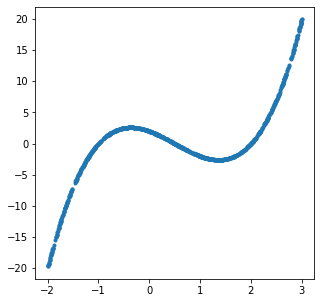

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:,0], data[:,1], marker=".")
plt.show()

# The Latent Space

Our generator is going to learn to map the uniform distribution $[0,1)$, denoted $U(0,1)$, into the space $(x,f(x))$. The following `sample_noise` function is used to obtain random noise for the generator.

In [5]:
def sample_noise(n_samples=256, low=0., high=1.):
    return np.random.uniform(low=low, high=high, size=(n_samples,1)).astype(np.float32)

# Adversarial Learning

## Models

### The Generator

Our generator network will have a single input and two outputs. The input to the network is the random noise we mapping to the data space of interested (i.e., the points $(x,f(x))$) and the output of the network is the point $(x,y)$. Our generator will consist of two fully connected hidden layers with 16 neurons each followed by leaky ReLU activation functions.

In [6]:
def generator(Z, reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z, 16, activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, 16, activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2, 2)
    return out

### The Discriminator

Our discriminator network will have two inputs and a single output. The input to the network is a point $(x,y)$ and the output of the network and the output are the [logits](https://developers.google.com/machine-learning/glossary#logits). Logits are raw non-normalized predictions that classification models generate. The logits from our model can be passed to the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) to obtain the normalized prediction between 0.0 and 1.0. Our discriminator will also consist of two fully connected hidden layers with 16 neurons each followed by leaky ReLU activation functions.

In [7]:
def discriminator(X, reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X, 16, activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, 16, activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,1)
    return out

# Adversarial Learning

## Placeholder Variables

We need to create two placeholder variables.

In [8]:
Z = tf.placeholder(tf.float32,[None,1])
X = tf.placeholder(tf.float32,[None,2])

## Compuate Graphs

We need to create a graph for getting samples from the generator and passing the real and generated samples to the discriminator.

In [9]:
sample_generator = generator(Z)
real_logits = discriminator(X)
fake_logits = discriminator(sample_generator, reuse=True)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


## Loss Functions

We are going to try to train our generator to learn a distribution $p_{g}$ of the real data $x$; let $p_{data}$ represent the true distribution of the data. The generator accomplishes this by mapping the random noise from the distribution $p_{z}$ (in this case, the uniform distribution $U(0,1)$) to $p_{g}$.

Let $G\left(z;\theta_{g}\right)$ be a function that maps the random noise $z$ to the space of real data, and let $D\left(x,\theta_{d}\right)$ be a function that represents the probability that $x$ comes from the true data distribution $p_{data}$ instead of the generator's learned distrobution $p_{g}$. Here, $\theta_{g}$ and $\theta_{d}$ represent the learnable parameters (i.e., weights) of the generator and discriminator, respectively. Then, the objective function from the original GAN [paper](https://arxiv.org/pdf/1406.2661.pdf) is as follows:

$$\min_{G}\max_{D}V\left(D,G\right)=\mathbb{E}_{x\sim p_{data}\left(x\right)}\left[\log D\left(x\right)\right]+\mathbb{E}_{z\sim p_{z}\left(z\right)}\left[\log\left(1-D\left(G\left(z\right)\right)\right)\right]$$

https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

In [10]:
discriminator_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits))
)

generator_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits))
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimizers

Here we define our optimizers.

In [11]:
discriminator_vars = tf.get_collection(
    tf.GraphKeys.GLOBAL_VARIABLES,
    scope="GAN/Discriminator"
)

discriminator_step = tf.train.RMSPropOptimizer(
    learning_rate=0.001
).minimize(
    discriminator_loss,
    var_list=discriminator_vars
)


generator_vars = tf.get_collection(
    tf.GraphKeys.GLOBAL_VARIABLES,
    scope="GAN/Generator"
)

generator_step = tf.train.RMSPropOptimizer(
    learning_rate=0.001
).minimize(
    generator_loss,
    var_list=generator_vars
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Training

The authors of the GAN paper suggest training the discriminator for several iterations followed by a single iteration of the generator for each training epoch. The following variables are used to control the training loop:
  * `n_epochs` - number of training loops
  * `batch_size` - the number of samples used in each loop of training
  * `n_discriminator_steps` - number of training steps applied to the discriminator in each epoch
  * `n_generator_steps` - number of training steps applied to the generator in each epoch

## Parameters

In [12]:
n_epochs = 10000
batch_size = 256
n_discriminator_steps = 10
n_generator_steps = 10

sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

## Training Loop

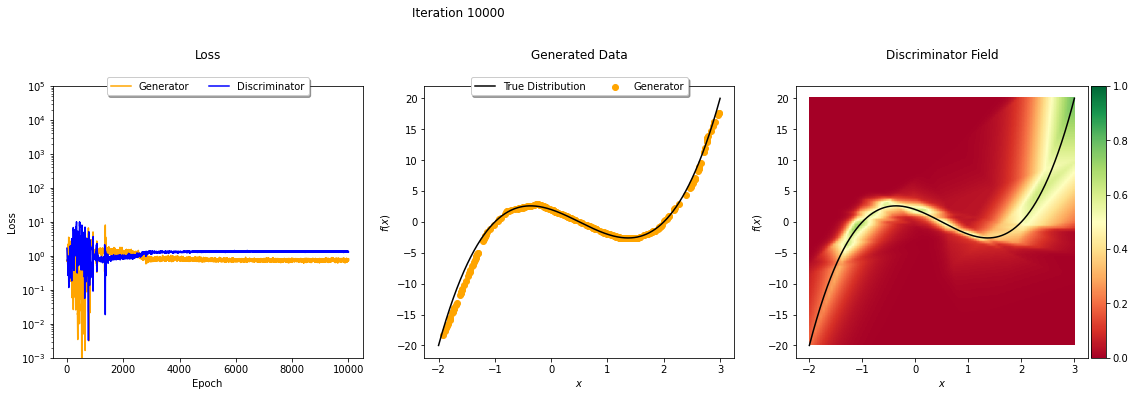

In [13]:
XX = np.linspace(data_vmin, data_vmax, 100)
YY = np.linspace(data_function(XX).min(), data_function(XX).max(), len(XX))
XX, YY = np.meshgrid(XX,YY)
POINTS = np.vstack([XX.ravel(), YY.ravel()]).T
POINTS = POINTS.astype(np.float32)

XX = np.linspace(data_vmin, data_vmax, 100000)
YY = data_function(XX)
NOISE = np.sort(sample_noise(batch_size), axis=0)
NOISE = NOISE.astype(np.float32)

discriminator_losses = list()
generator_losses = list()
for epoch in range(1,n_epochs+1):
    idx = np.random.randint(len(data), size=batch_size)
    batch_samples = data[idx,:]
    batch_noise = sample_noise(batch_size)

    for ii in range(n_discriminator_steps):
        _, dloss = sess.run([discriminator_step, discriminator_loss], feed_dict={X:batch_samples, Z:batch_noise})
    discriminator_losses.append(dloss)

    for ii in range(n_generator_steps):
        _, gloss = sess.run([generator_step, generator_loss], feed_dict={Z: batch_noise})
    generator_losses.append(gloss)
    
    if epoch % 100 == 0:
        sample = sess.run(sample_generator, feed_dict={Z: batch_noise}).astype(float)
        predictions = sess.run(real_logits, feed_dict={X: POINTS}).flatten()
        colors = np.exp(-np.logaddexp(0, -predictions))
        colors = colors.reshape(int(len(colors)**.5),-1)
        
        clear_output(wait=True)
        
        gs = mpl.gridspec.GridSpec(1,3)
        fig = plt.figure(figsize=(15,5))
        fig.suptitle("Iteration {}".format(epoch), y=1.1)
        fig.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=None)
        
        ax = fig.add_subplot(gs[0])
        ax.plot(generator_losses, color="orange", label="Generator")
        ax.plot(discriminator_losses, color="blue", label="Discriminator")
        ax.set_title("Loss", y=1.08)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_yscale("log")
        ax.set_ylim(10**-3,10**5)
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=3,
            fancybox=True,
            shadow=True
        )
        
        ax = fig.add_subplot(gs[1])
        ax.plot(XX, YY, color="black", label="True Distribution", zorder=1)
        ax.scatter(
            sample[:,0],
            sample[:,1],
            color="orange",
            label="Generator",
            zorder=0
        )
        ax.set_title("Generated Data", y=1.08)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$f(x)$")
        ax.set_xlim(XX.min()-0.05*(XX.max()-XX.min()), XX.max()+0.05*(XX.max()-XX.min()))
        ax.set_ylim(YY.min()-0.05*(YY.max()-YY.min()), YY.max()+0.05*(YY.max()-YY.min()))
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=3,
            fancybox=True,
            shadow=True
        )
        
        ax = fig.add_subplot(gs[2])
        ax.plot(XX, YY, color="black", label="True Distribution", zorder=1)
        img = ax.imshow(
            colors,
            cmap="RdYlGn",
            aspect="auto",
            vmin=0.,
            vmax=1.,
            origin="lower",
            extent=[
                XX.min(), 
                XX.max(),
                YY.min(),
                YY.max()
            ],
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(img, cax=cax)
        ax.set_title("Discriminator Field", y=1.08)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$f(x)$")
        ax.set_xlim(XX.min()-0.05*(XX.max()-XX.min()), XX.max()+0.05*(XX.max()-XX.min()))
        ax.set_ylim(YY.min()-0.05*(YY.max()-YY.min()), YY.max()+0.05*(YY.max()-YY.min()))
        ax.set_aspect("auto")
        
        plt.show()